In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

import scipy.sparse as sparse

%matplotlib inline

from implicit.als import AlternatingLeastSquares

In [3]:
raw_data = pd.read_table('./lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv')

/Users/aleksandr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [4]:
raw_data = raw_data.drop(raw_data.columns[1], axis=1)
raw_data.columns = ['user', 'artist', 'plays']

raw_data.head()

,user,artist,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
1,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
2,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
3,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
4,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691


In [7]:
data = raw_data.dropna()

In [8]:
data.loc[[1,2]]

,user,artist,plays
1,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
2,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717


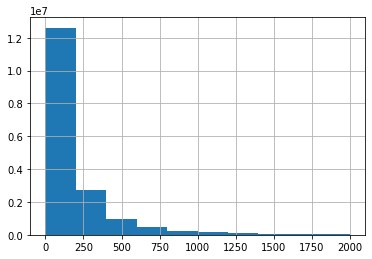

In [9]:
data.iloc[np.where(data.plays < 2000)].plays.hist()

In [10]:
data['user_id'] = data['user'].astype("category").cat.codes
data['artist_id'] = data['artist'].astype("category").cat.codes

data.head()

/Users/aleksandr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/aleksandr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,user,artist,plays,user_id,artist_id
0,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099,0,90933
1,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897,0,185367
2,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717,0,106704
3,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706,0,155241
4,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691,0,220128


In [13]:
item_lookup = data[['artist_id', 'artist']].drop_duplicates()
item_lookup['artist_id'] = item_lookup.artist_id.astype(str)

item_lookup.head()

,artist_id,artist
0,90933,die Ärzte
1,185367,melissa etheridge
2,106704,elvenking
3,155241,juliette & the licks
4,220128,red hot chili peppers


In [14]:
artist_id_name = {}

for index, row in tqdm_notebook(item_lookup.iterrows()):
    artist_id_name[row.artist_id] = row.artist

In [15]:
data = data.drop(['user', 'artist'], axis=1)

In [16]:
data.head()

,plays,user_id,artist_id
0,1099,0,90933
1,897,0,185367
2,717,0,106704
3,706,0,155241
4,691,0,220128


In [17]:
data = data.loc[data.plays != 0]

In [18]:
data.head()

,plays,user_id,artist_id
0,1099,0,90933
1,897,0,185367
2,717,0,106704
3,706,0,155241
4,691,0,220128


In [19]:
users = list(np.sort(data.user_id.unique()))
artists = list(np.sort(data.artist_id.unique()))
plays = list(data.plays)

In [22]:
print(users[:5])
print(artists[:5])
print(plays[:5])

[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[1099, 897, 717, 706, 691]


In [26]:
rows = data.user_id.astype(int)
cols = data.artist_id.astype(int)

In [29]:
print(len(users), len(artists), len(plays))
print(len(rows), len(cols))

358868 292363 17535449
17535449 17535449


In [30]:
data_sparse = sparse.csr_matrix((plays, (cols, rows)), shape=(len(artists), len(users)))

In [32]:
model = AlternatingLeastSquares(factors=50)
model.fit(data_sparse)

In [33]:
userid = 0

user_items = data_sparse.T.tocsr()
recommendations = model.recommend(userid, user_items)

In [34]:
recommendations

[(161833, 1.5396787),
 (116811, 1.4974153),
 (107103, 1.4211016),
 (255208, 1.3278283),
 (140813, 1.2694366),
 (205613, 1.2568821),
 (165921, 1.2557843),
 (30159, 1.2135193),
 (255123, 1.2011342),
 (252769, 1.192286)]

In [35]:
for r in recommendations:
    print(artist_id_name[str(r[0])])

kittie
flyleaf
emilie autumn
the dresden dolls
in this moment
otep
lacuna coil
arch enemy
the donnas
the birthday massacre


In [36]:
itemid = 107209
related = model.similar_items(itemid)

In [37]:
related

[(107209, 0.25651798),
 (157178, 0.2518177),
 (80959, 0.24820252),
 (96013, 0.24787116),
 (137230, 0.24776852),
 (239422, 0.24761362),
 (155893, 0.24746972),
 (99769, 0.24729533),
 (72721, 0.24715614),
 (171964, 0.24703248)]

In [40]:
model.explain(0, user_items, 116811)

(1.4387654902138858,
 [(223386, 0.148888009146795),
  (184079, 0.14308532395679704),
  (278311, 0.142809496944708),
  (177597, 0.13091462742824048),
  (144293, 0.12551679201530333),
  (92172, 0.10984442371903348),
  (228759, 0.09429139646121254),
  (129383, 0.09122734071365503),
  (220128, 0.07814960448742955),
  (151766, 0.07374818659389196)],
 (array([[3.00471203, 1.45048224, 1.62170101, ..., 1.85493663, 2.24797877,
          1.37743141],
         [4.35828143, 1.85444306, 0.85577696, ..., 0.7258874 , 0.80247576,
          1.05043986],
         [4.87274453, 3.93923815, 1.86503682, ..., 0.85594981, 0.5595121 ,
          0.7181783 ],
         ...,
         [5.5735504 , 4.03666949, 5.22572823, ..., 1.29172447, 0.05078946,
          0.00867104],
         [6.75452884, 4.74879889, 5.37580037, ..., 6.10070422, 1.23257808,
          0.05371654],
         [4.13878473, 3.94592071, 4.47215313, ..., 4.89120042, 4.97365152,
          1.25079028]]), False))

In [38]:
for a in related:
    print(artist_id_name[str(a[0])])

eminem
kanye west
damian marley/damian marley/damian marley
dj scream & dj smallz
hot karl
sonic youth & cypress hill
justin timberlake
dr. namagiripettai krishnan
clipse feat. pharrell williams
living colour & run d.m.c.


In [39]:
artist_id_name['234786']

'sick on the bus'

In [ ]:
pass

Требуется построить модель рекомендаций на основе скрытых факторов (implicit) на основе dataset’а \
https://grouplens.org/datasets/hetrec-2011/ (Delicious Bookmarks)


- Documentation: [implicit](https://implicit.readthedocs.io/en/latest/quickstart.html)\
**!pip install implicit**


- Requirements:
This library requires SciPy version 0.16 or later. Running on OSX requires an OpenMP compiler, which can be installed with homebrew:\
**!brew install gcc**.

In [32]:
raw_data = pd.read_table('./hetrec2011-delicious-2k/user_taggedbookmarks-timestamps.dat', usecols=['userID','bookmarkID','tagID'])
raw_data = raw_data.groupby(['userID', 'bookmarkID'], as_index=False)['tagID'].count()
raw_data.columns = ['userID', 'bookmarkID', 'tagCount']

data = raw_data.copy()
data = data.dropna()

data['userID'] = data['userID'].astype("category").cat.codes
data['bookmarkID'] = data['bookmarkID'].astype("category").cat.codes

users = list(np.sort(data.userID.unique()))
bookmarks = list(np.sort(data.bookmarkID.unique()))
tags = list(data.tagCount)

# print(users[:5])
# print(bookmarks[:5])
# print(tags[:5])

rows = data.userID.astype(int)
cols = data.bookmarkID.astype(int)

# print()
# print(len(users), len(bookmarks), len(tags))
# print(len(rows), len(cols))

data_sparse = sparse.csr_matrix((tags, (cols, rows)), shape=(len(bookmarks), len(users)))

model = AlternatingLeastSquares(factors=100)
model.fit(data_sparse)

userid = 10 #!
user_items = data_sparse.T.tocsr()
recommendations = model.recommend(userid, user_items)

titles_bookmarks = pd.read_table('./hetrec2011-delicious-2k/bookmarks.dat', usecols=['id','title'], sep='\\n', delimiter='\\t')

rec_ids = np.array(recommendations)[:, 0]

itemid = 15366 #!
related = model.similar_items(itemid)

rel_ids = np.array(related)[:, 0]

/Users/aleksandr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


/Users/aleksandr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: read_table is deprecated, use read_csv instead.
/Users/aleksandr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [33]:
display(titles_bookmarks.query("id in @rec_ids"))
display(titles_bookmarks.query("id in @rel_ids"))

,id,title
450,616,50 CMS Alternatives to WordPress | Design Shack
452,618,JavaScript Guide - MDC
456,624,5 Leading Airline Booking Forms Tested for Usa...
459,627,A List Apart: Articles: The Look That Says Book
462,631,Showcase Of Appetizing Restaurant Websites - S...
478,647,50 Tremendous Grunge Wallpapers For Your Deskt...
484,655,Worldy Inspiration from Tourism Websites | Web...


,id,title
10802,15373,Education/Projects/JetpackForLearning/Profiles...
10803,15374,Heuristics for User Interface Design
10804,15376,annalist » Neulich bei Twitter: Post-Privacy o...
10806,15380,"Drumbeat Learning, Freedom and the Web Festiva..."


In [ ]:
pass